# Objective

For this competition, your objective is to predict whether a user will download an app after clicking a mobile app advertisement.  

**File descriptions**  

    train.csv - the training set
    train_sample.csv - 100,000 randomly-selected rows of training data, to inspect data before downloading full set
    test.csv - the test set
    sampleSubmission.csv - a sample submission file in the correct format

**Data fields**  
Each row of the training data contains a click record, with the following features.

    ip: ip address of click.
    app: app id for marketing.
    device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
    os: os version id of user mobile phone
    channel: channel id of mobile ad publisher
    click_time: timestamp of click (UTC)
    attributed_time: if user download the app for after clicking an ad, this is the time of the app download
    is_attributed: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

    click_id: reference for making predictions
    is_attributed: not included

# Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import os

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

# Path

In [2]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

# Reading data

In [3]:
train = pd.read_csv(datapath + "train.csv")
print('Number of clicks in training set: %d' %len(train))

Number of clicks in training set: 184903890


In [4]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [ ]:
print('Average response in training set: %d' %np.mean(train['is_attributed']))

In [5]:
test = pd.read_csv(datapath + "test.csv")
print('Number of clicks in test set: %d' %len(test))

Number of clicks in test set: 18790469


In [6]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


# Datetime features

In [7]:
# extract the day
train['day'] = train['click_time'].apply(lambda x:x[8:10])
test['day'] = test['click_time'].apply(lambda x:x[8:10])
# extract the hour
train['hour'] = train['click_time'].apply(lambda x:x[11:13])
test['hour'] = test['click_time'].apply(lambda x:x[11:13])

In [8]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,06,14
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,06,14
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,06,14
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,06,14
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,06,14


# Analyzing IP addresses

In [9]:
# get unique IP addresses
ip_train = pd.unique(train['ip'])
ip_test = pd.unique(test['ip'])

In [10]:
# Find IPs in common
ip_in_common = np.intersect1d(ip_train, ip_test)
print('Found %d IP addresses in common.' %len(ip_in_common))

Found 38164 IP addresses in common.


In [11]:
# Percentage of IPs in test that are in train
print('Percentage of test IP adrresses that are in train: %d percent' % np.round(100*len(ip_in_common)/len(ip_test)))

Percentage of test IP adrresses that are in train: 41 percent


In [ ]:
# Percentage of IPs in test that are in train
print('Percentage of test rows with IP in train: %d percent' % len(test[test.ip.isin(train.ip.unique())]) / float(len(test)))
# ~90%

In [12]:
# range of IPs in train
print('First IP in train: %d' % np.min(ip_train))
print('Last IP in train:  %d' % np.max(ip_train))

First IP in train: 1
Last IP in train:  364778


In [13]:
# range of IPs in test
print('First IP in test: %d' % np.min(ip_test))
print('Last IP in test:  %d' % np.max(ip_test))

First IP in test: 0
Last IP in test:  126413


In [14]:
# Brief look at first train ips
print(list(np.sort(ip_train)[1:10]))

[5, 6, 9, 10, 19, 20, 25, 27, 31]


In [15]:
# Brief look at first test ips
print(list(np.sort(ip_test)[1:10]))

[1, 2, 3, 4, 5, 6, 9, 10, 12]


In [16]:
# Brief look at last train ips
print(list(np.sort(ip_train))[:-10:-1])

[364778, 364777, 364776, 364775, 364774, 364773, 364772, 364771, 364770]


In [17]:
# Brief look at last test ips
print(list(np.sort(ip_test))[:-10:-1])

[126413, 126412, 126411, 126410, 126409, 126408, 126406, 126405, 126404]


# Click time range

In [18]:
print('Click time range in train: \t %s --> %s' %(np.min(train['click_time']), np.max(train['click_time'])))
print('Click time range in test:  \t %s --> %s' %(np.min(test['click_time']), np.max(test['click_time'])))

Click time range in train: 	 2017-11-06 14:32:21 --> 2017-11-09 16:00:00
Click time range in test:  	 2017-11-10 04:00:00 --> 2017-11-10 15:00:00


# Subsampling

In [49]:
np.random.seed(2210)
subtrain = train.sample(frac=0.1, replace=False)
subtest = test.sample(frac=0.1, replace=False)

In [50]:
subtrain.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour
120980889,13135,3,1,42,280,2017-11-08 15:37:38,NaN,0,08,15
21415488,93765,3,1,18,280,2017-11-07 03:39:26,NaN,0,07,03
132867385,14475,3,2,9,280,2017-11-09 00:17:45,NaN,0,09,00
154700696,59955,18,1,17,107,2017-11-09 06:38:08,NaN,0,09,06
85666610,30249,2,1,13,477,2017-11-08 04:57:36,NaN,0,08,04


# Clicks per day

Text(0.5,1,'Clicks per day (Training set)')

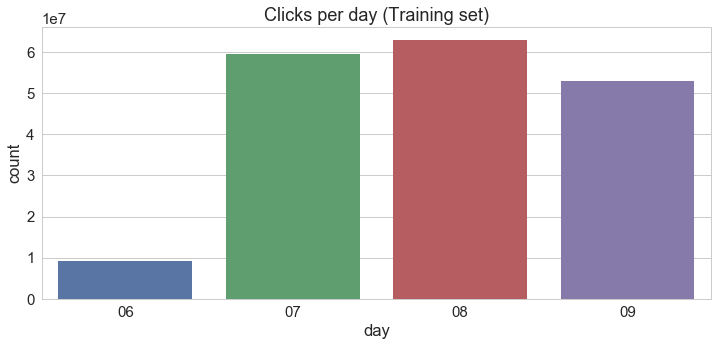

In [21]:
df = pd.DataFrame(train.groupby(['day']).size(), columns=['count'])
sns.barplot(x=df.index, y=df['count']).set_title('Clicks per day (Training set)')

In [22]:
"""sns.countplot(x='day',data=subtrain)"""

"sns.countplot(x='day',data=subtrain)"

# Clicks per hour

Text(0.5,1,'Clicks per hour (Training set)')

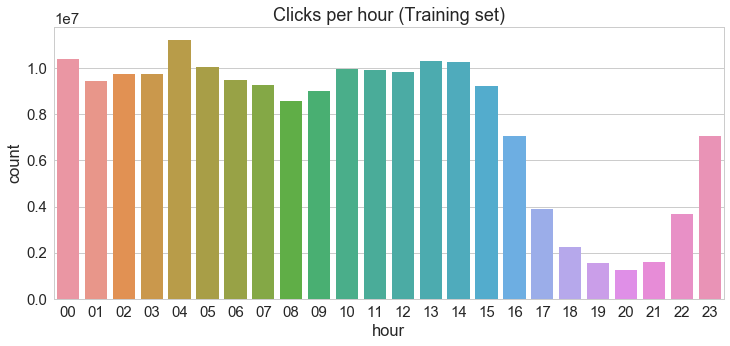

In [23]:
df = pd.DataFrame(train.groupby(['hour']).size(), columns=['count'])
sns.barplot(x=df.index, y=df['count']).set_title('Clicks per hour (Training set)')

Text(0.5,1,'Clicks per hour (Test set)')

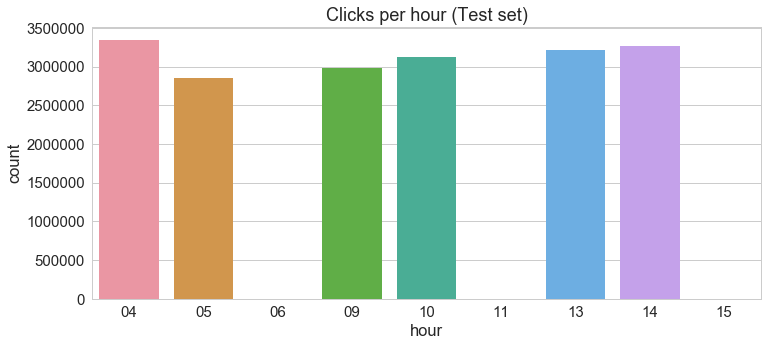

In [24]:
df = pd.DataFrame(test.groupby(['hour']).size(), columns=['count'])
sns.barplot(x=df.index, y=df['count']).set_title('Clicks per hour (Test set)')

# Clicks through time

/Users/a008495/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/a008495/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5,1,'Clicks through time (Training set)')

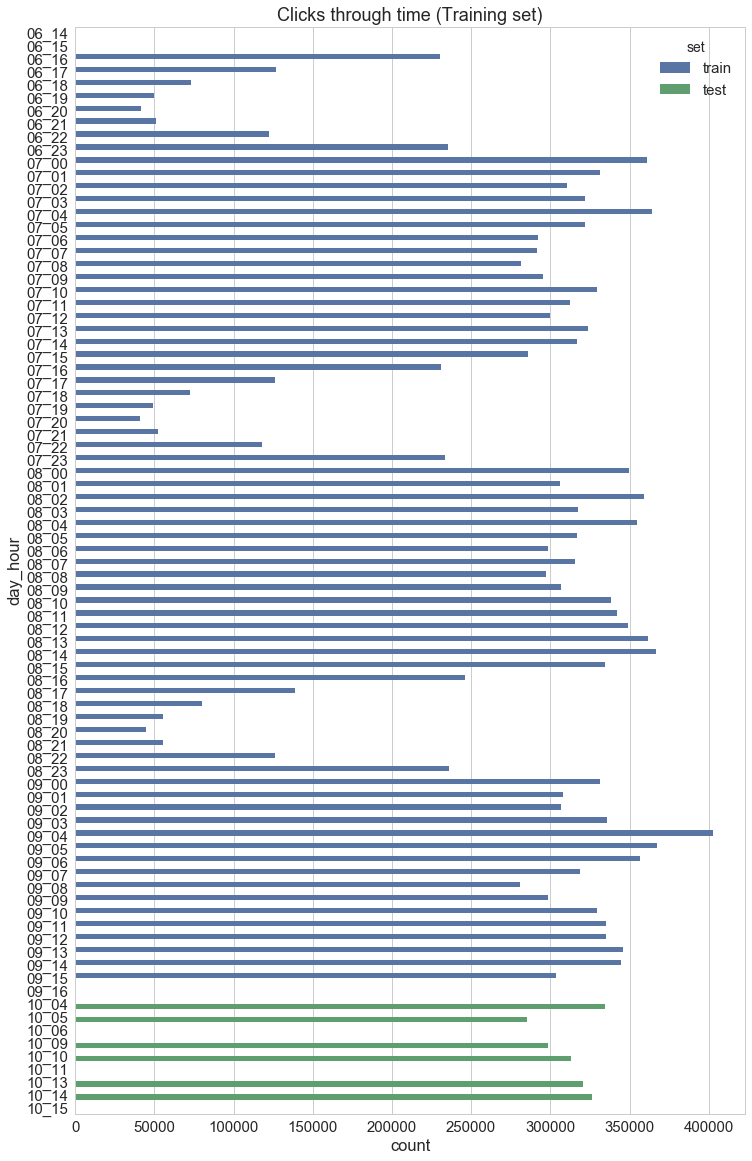

In [58]:
# on training set
df0 = subtrain[['day', 'hour']]
df0['day_hour'] = df0['day'] + '_' + df0['hour']
df1 = pd.DataFrame(df0.groupby(['day_hour']).size(), columns=['count'])
df1.reset_index(inplace=True)
del(df0)

# on test set
df0 = subtest[['day', 'hour']]
df0['day_hour'] = df0['day'] + '_' + df0['hour']
df2 = pd.DataFrame(df0.groupby(['day_hour']).size(), columns=['count'])
df2.reset_index(inplace=True)
del(df0)

df1['set'] = 'train'
df2['set'] = 'test'
df3 = pd.concat([df1, df2], ignore_index=True)

f, ax = plt.subplots(figsize=(12, 20))
sns.barplot(x='count', y='day_hour', data=df3, hue='set', orient='h').set_title('Clicks through time (Training set)')

# Conversion through time

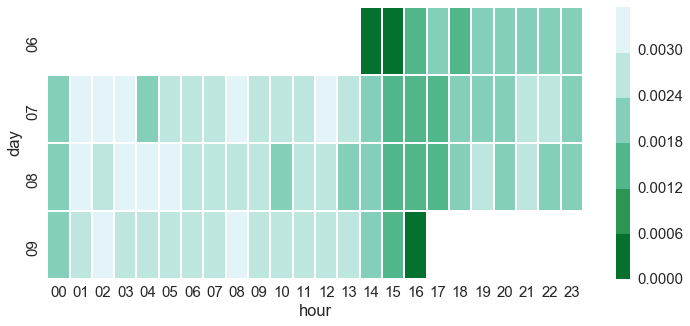

In [52]:
conv_rates = subtrain.groupby(['day', 'hour'])['is_attributed'].mean()
conv_rates = pd.DataFrame(conv_rates).pivot_table(values='is_attributed', index='day', columns='hour')
sns.heatmap(conv_rates,cmap=sns.color_palette("BuGn_r"),linecolor='white',linewidths=1)

# Conversion through hours

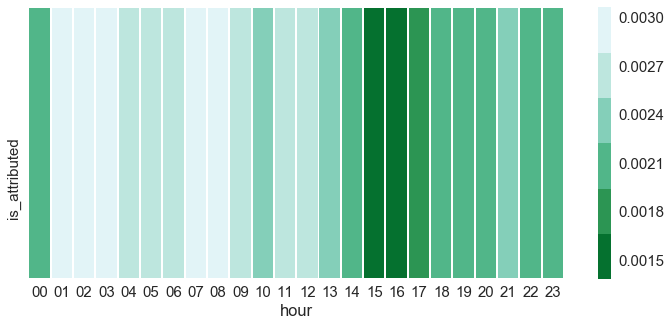

In [53]:
conv_rates = subtrain.groupby(['hour'])['is_attributed'].mean()
conv_rates = pd.DataFrame(conv_rates).pivot_table(values='is_attributed', columns='hour')
sns.heatmap(conv_rates,cmap=sns.color_palette("BuGn_r"),linecolor='white',linewidths=1)

In [54]:
conv_rates = subtrain.groupby(['hour'])['is_attributed'].mean()
layout = cf.Layout(height=330, width=980, title='Conversion rate through hours')
pd.DataFrame(conv_rates)['is_attributed'].iplot(kind='scatter',
                                                width=3,
                                                layout=layout)

# Conversion through days

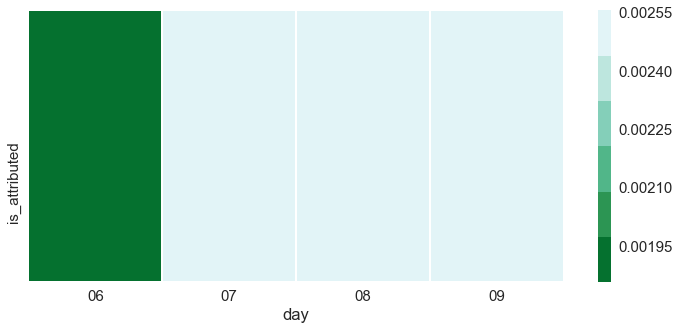

In [55]:
conv_rates = subtrain.groupby(['day'])['is_attributed'].mean()
conv_rates = pd.DataFrame(conv_rates).pivot_table(values='is_attributed', columns='day')
sns.heatmap(conv_rates,cmap=sns.color_palette("BuGn_r"),linecolor='white',linewidths=1)

# Number of levels in categorical variables

In [56]:
cols = ['ip', 'app', 'device', 'os', 'channel']
nblevels = [train[c].nunique() for c in cols]

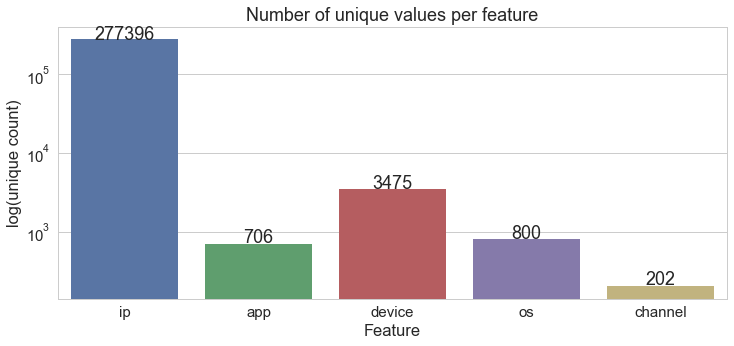

In [57]:
ax = sns.barplot(cols, nblevels, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, levels in zip(ax.patches, nblevels):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            levels,
            ha="center") 